перед работой следует создать/активировать виртуалку и в ней установить pytorch, желательно с остальными либами 
python -m venv pinn_env //у Олега
команда для запуска виртуалки . ./pinn_env/bin/activate из директории PINN
pip3 install torch torchvision так я pytorch поставил (в виртуалку)


create_graph=True — САМЫЙ ВАЖНЫЙ ПАРАМЕТР для PINN!

Сохраняет вычислительный граф для ВТОРОГО дифференцирования
Без этого мы не сможем вычислить u_xxx (третью производную)
Если False — граф уничтожается после первого дифференцирования


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



#задаем область определения функции, можно поменять по запросу
L = 2.0  
T = 1.0  
n_points = 100  # количество точек по каждому измерению, чем больше тем точнее

if 'model' not in locals():  
    class KdVNet(nn.Module):
        def __init__(self, hidden_size=20, num_layers=3):
            super().__init__()
            layers = []
            layers.append(nn.Linear(2, hidden_size))
            layers.append(nn.Tanh())
            for _ in range(num_layers - 1):
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.Tanh())
            layers.append(nn.Linear(hidden_size, 1))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x)
    
    model = KdVNet(hidden_size=20, num_layers=3)

x_domain = torch.linspace(-L, L, n_points, requires_grad=False)
t_domain = torch.linspace(0, T, n_points, requires_grad=False)
domain_points = torch.cartesian_prod(x_domain, t_domain)

x_bc_dirichlet = torch.tensor([-L, L])
t_bc_dirichlet = torch.linspace(0, T, n_points, requires_grad=False)
bc_dirichlet_points = torch.cartesian_prod(x_bc_dirichlet, t_bc_dirichlet)

x_bc_neumann = torch.tensor([-L])
t_bc_neumann = torch.linspace(0, T, n_points, requires_grad=False)
bc_neumann_points = torch.cartesian_prod(x_bc_neumann, t_bc_neumann)

x_initial = torch.linspace(-L, L, n_points, requires_grad=False)
t_initial = torch.Tensor([0])
initial_points = torch.cartesian_prod(x_initial, t_initial)


def calculate_total_loss(model, domain_points, bc_dirichlet_points, bc_neumann_points, initial_points):
    total_loss = 0.0
    x_bc = bc_dirichlet_points[:, 0:1].requires_grad_(False)  
    t_bc = bc_dirichlet_points[:, 1:2].requires_grad_(False)
    u_pred_bc = model(bc_dirichlet_points)
    loss_bc_dirichlet = (u_pred_bc ** 2).mean()

    x_initial = initial_points[:, 0:1].requires_grad_(False)  
    t_initial = initial_points[:, 1:2].requires_grad_(False)
    u_pred_initial = model(initial_points)
    f_x = torch.sin(torch.pi * x_initial / L)
    loss_initial = ((u_pred_initial - f_x) ** 2).mean()

    x_neumann = bc_neumann_points[:, 0:1].requires_grad_(True)  #нужны градиенты
    t_neumann = bc_neumann_points[:, 1:2].requires_grad_(False)
    points_neumann = torch.cat([x_neumann, t_neumann], dim=1)
    u_pred_neumann = model(points_neumann)
    u_x_neumann = torch.autograd.grad(u_pred_neumann , x_neumann , grad_outputs=torch.ones_like(u_pred_neumann), create_graph=True)[0]
    loss_bc_neumann = (u_x_neumann ** 2).mean()

    x_eq = domain_points[:, 0:1].requires_grad_(True)  
    t_eq = domain_points[:, 1:2].requires_grad_(True)   
    points_eq = torch.cat([x_eq, t_eq], dim=1)
    u = model(points_eq)
    u_t = torch.autograd.grad(u, t_eq, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_eq, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_eq, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x_eq, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]
    residual = u_t + 6 * u * u_x + u_xxx
    loss_equation = (residual ** 2).mean()


    total_loss += loss_bc_dirichlet + loss_initial + loss_bc_neumann + loss_equation    
    return total_loss


loss = calculate_total_loss(model, domain_points, bc_dirichlet_points, bc_neumann_points, initial_points)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(2001):
    optimizer.zero_grad()  
    
    total_loss = calculate_total_loss(model, domain_points, bc_dirichlet_points, 
                                    bc_neumann_points, initial_points)
    
    total_loss.backward()
    
    optimizer.step()
    
    if epoch % 100 == 0:
        print('||')
        print('\\/')
        print(f"Эпоха {epoch}, Общие потери: {total_loss.item():.6f}")
        

# Создаем сетку для визуализации
x_vis = torch.linspace(-L, L, 100)
t_vis = torch.linspace(0, T, 50)
X, T_vis = torch.meshgrid(x_vis, t_vis, indexing='xy')
points_vis = torch.stack([X.flatten(), T_vis.flatten()], dim=1)

# вычисляем предсказание обученной модели
with torch.no_grad():
    u_pred = model(points_vis).reshape(X.shape)

# визуализируем 2д градиент
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.contourf(T_vis.numpy(), X.numpy(), u_pred.numpy(), levels=50, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('Время (t)')
plt.ylabel('Координата (x)')
plt.title('Решение уравнения КдВ с помощью PINN')
plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Создаем 3D график
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(T_vis.numpy(), X.numpy(), u_pred.numpy(), 
                      cmap='viridis', alpha=0.8, linewidth=0, 
                      antialiased=True, rstride=2, cstride=2)

ax.set_xlabel('Время (t)')
ax.set_ylabel('Координата (x)')
ax.set_zlabel('u(x,t)')
ax.set_title('Решение уравнения КдВ методом PINN')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Улучшаем обзор
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()








||
\/
Эпоха 0, Общие потери: 0.458420


KeyboardInterrupt: 

In [3]:
#исследование разных архитектур
#блок создания общий, тест будет в разных

def create_kdv_model(hidden_size, num_layers):
    """Создает модель с заданной архитектурой"""
    layers = []
    
    # Входной слой
    layers.append(nn.Linear(2, hidden_size))
    layers.append(nn.Tanh())
    
    # Скрытые слои
    for _ in range(num_layers - 1):
        layers.append(nn.Linear(hidden_size, hidden_size))
        layers.append(nn.Tanh())
    
    # Выходной слой
    layers.append(nn.Linear(hidden_size, 1))
    
    return nn.Sequential(*layers)

# Тестируем функцию
test_model = create_kdv_model(hidden_size=20, num_layers=3)
print("Тестовая модель создана!")
print(f"Количество параметров: {sum(p.numel() for p in test_model.parameters())}")

def train_and_evaluate_model(hidden_size, num_layers, epochs=500):
    """Обучает модель и возвращает финальные потери"""
    print(f"\n--- Архитектура: {num_layers} слоя, {hidden_size} нейронов ---")  
    
    # Создаем модель
    model = create_kdv_model(hidden_size, num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Списки для отслеживания потерь
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        total_loss = calculate_total_loss(model, domain_points, bc_dirichlet_points, 
                                        bc_neumann_points, initial_points)
        total_loss.backward()
        optimizer.step()
        
        losses.append(total_loss.item())
        
        if epoch % 100 == 0:
            print(f"Эпоха {epoch}: loss = {total_loss.item():.6f}")
    
    final_loss = losses[-1]
    print(f"Финальные потери: {final_loss:.6f}")
    
    return final_loss, losses, model

Тестовая модель создана!
Количество параметров: 921


In [4]:
# Тестируем минимальную архитектуру
final_loss_0, losses_0, model_0 = train_and_evaluate_model(hidden_size=5, num_layers=1, epochs=300)


--- Архитектура: 1 слоя, 5 нейронов ---
Эпоха 0: loss = 0.667186
Эпоха 100: loss = 0.427768
Эпоха 200: loss = 0.402838
Финальные потери: 0.389905


In [5]:
#Тестируем простую архитектуру
final_loss_1, losses_1, model_1 = train_and_evaluate_model(hidden_size=10, num_layers=2, epochs=300)


--- Архитектура: 2 слоя, 10 нейронов ---
Эпоха 0: loss = 0.456244
Эпоха 100: loss = 0.366926
Эпоха 200: loss = 0.289855
Финальные потери: 0.231889


In [6]:
#Тестируем среднюю архитектуру  
final_loss_2, losses_2, model_2 = train_and_evaluate_model(hidden_size=20, num_layers=3, epochs=300)


--- Архитектура: 3 слоя, 20 нейронов ---
Эпоха 0: loss = 0.608749
Эпоха 100: loss = 0.366690
Эпоха 200: loss = 0.267090
Финальные потери: 0.200089


In [7]:
#Тестируем сложную архитектуру
final_loss_3, losses_3, model_3 = train_and_evaluate_model(hidden_size=50, num_layers=4, epochs=300)


--- Архитектура: 4 слоя, 50 нейронов ---
Эпоха 0: loss = 0.691777
Эпоха 100: loss = 0.239943
Эпоха 200: loss = 0.193046
Финальные потери: 0.185734


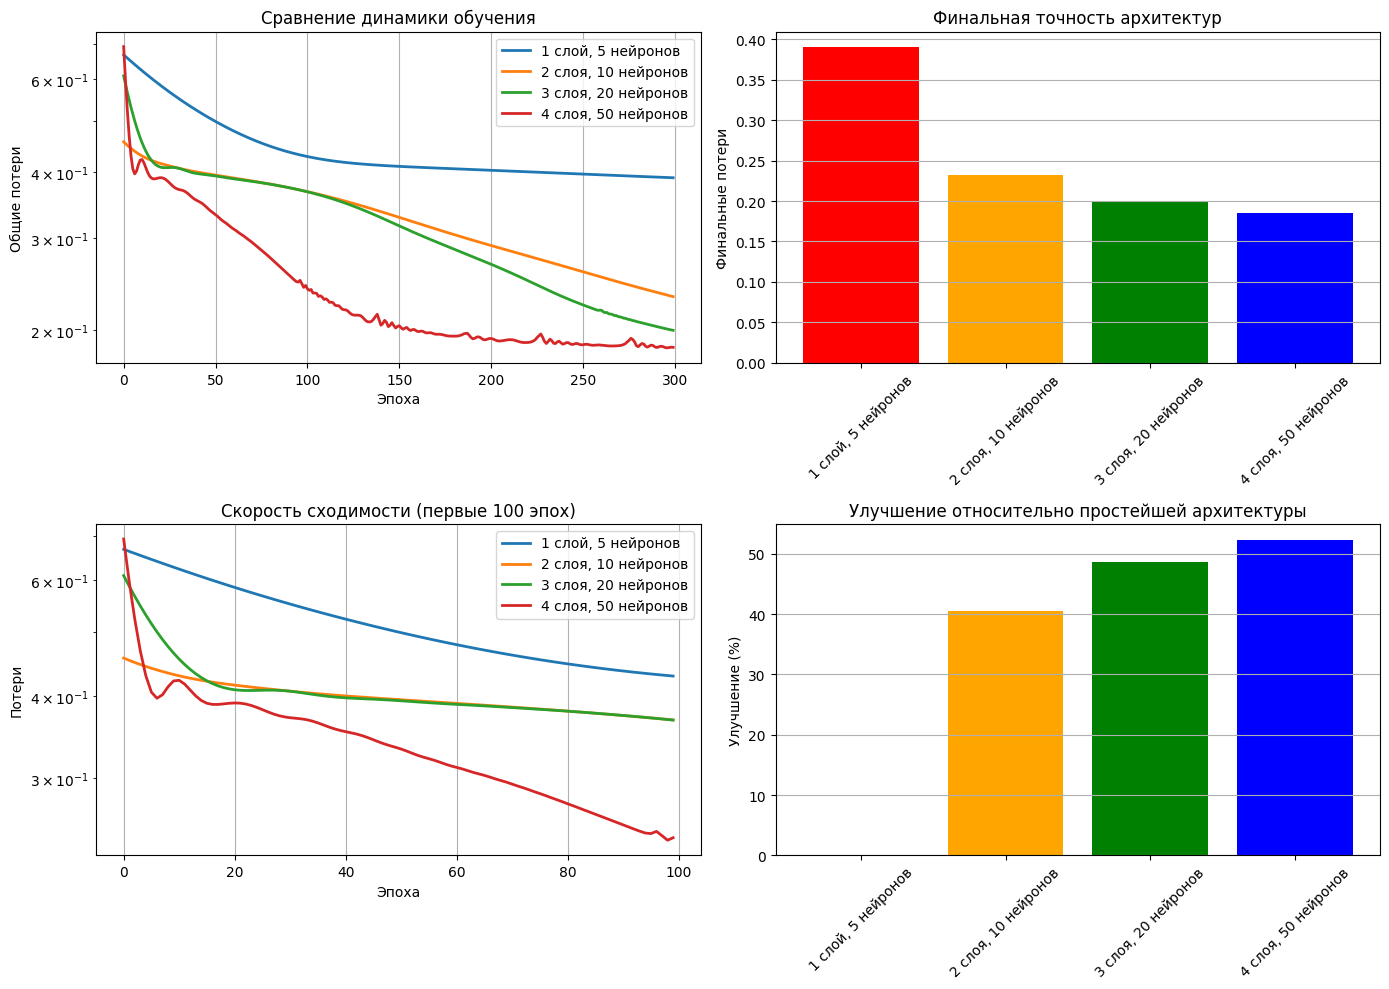

In [8]:
# Создаем список всех архитектур и их потерь
architectures = [
    ("1 слой, 5 нейронов", losses_0),
    ("2 слоя, 10 нейронов", losses_1), 
    ("3 слоя, 20 нейронов", losses_2),
    ("4 слоя, 50 нейронов", losses_3)
]

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
for name, losses in architectures:
    plt.plot(losses, label=name, linewidth=2)
plt.xlabel('Эпоха')
plt.ylabel('Общие потери')
plt.title('Сравнение динамики обучения')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.subplot(2, 2, 2)
names = [arch[0] for arch in architectures]
final_losses = [arch[1][-1] for arch in architectures]
plt.bar(names, final_losses, color=['red', 'orange', 'green', 'blue'])
plt.ylabel('Финальные потери')
plt.title('Финальная точность архитектур')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.subplot(2, 2, 3)
for name, losses in architectures:
    plt.plot(losses[:100], label=name, linewidth=2)
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Скорость сходимости (первые 100 эпох)')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.subplot(2, 2, 4)
baseline = final_losses[0]  
improvement = [(baseline - loss) / baseline * 100 for loss in final_losses]
plt.bar(names, improvement, color=['red', 'orange', 'green', 'blue'])
plt.ylabel('Улучшение (%)')
plt.title('Улучшение относительно простейшей архитектуры')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


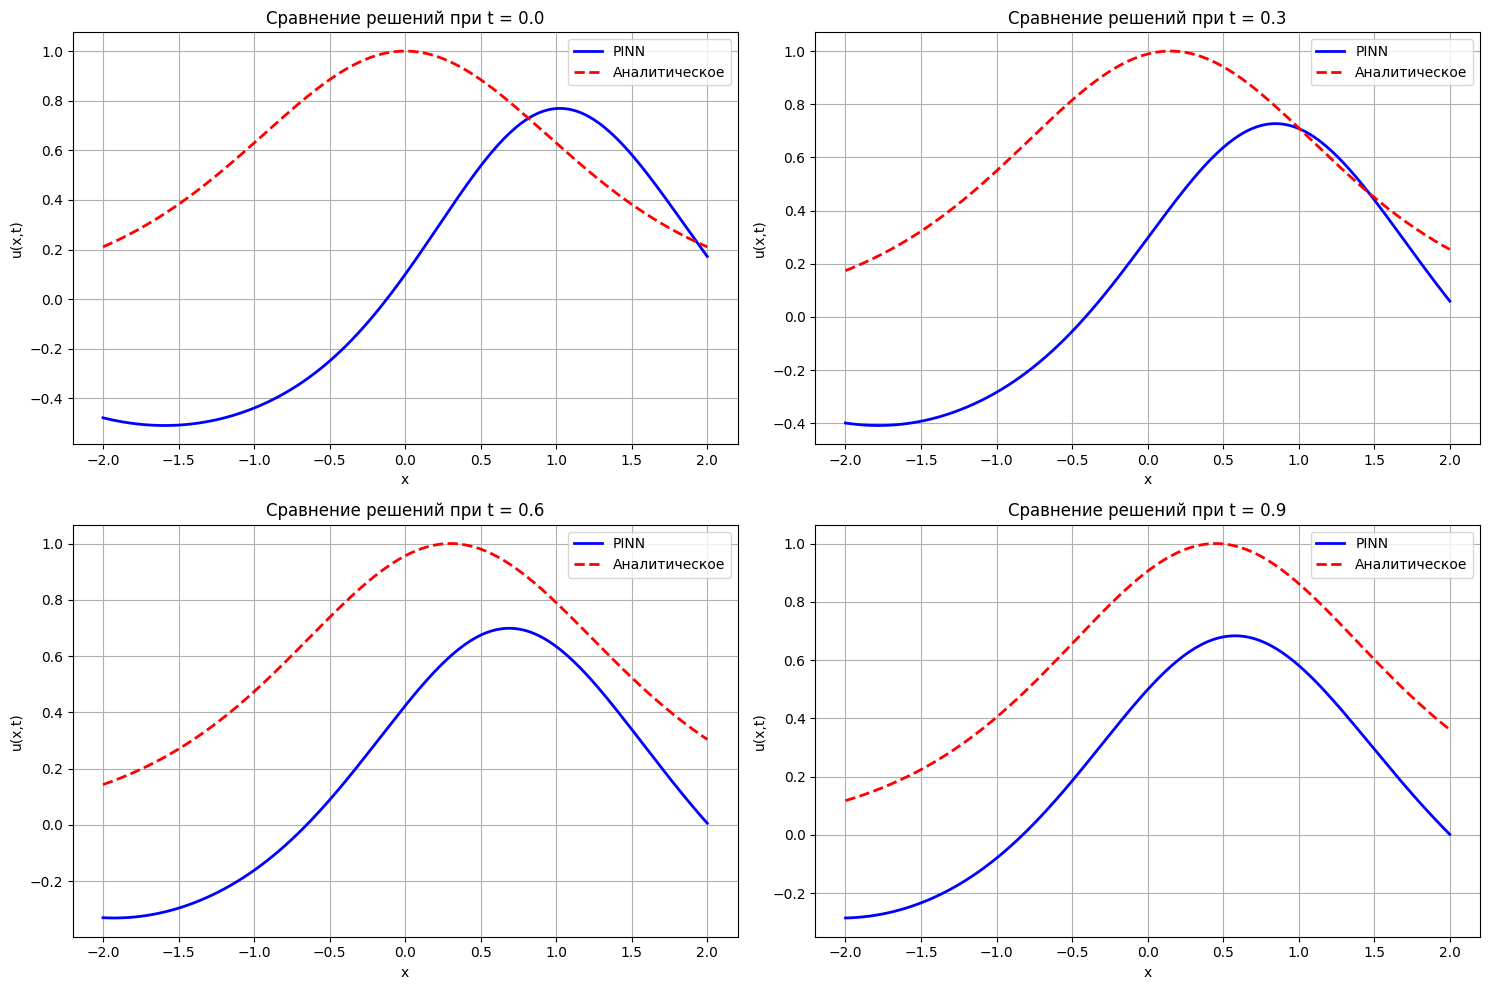

In [9]:
# Аналитическое решение уравнения КдВ (солитон)
def analytical_kdv_solution(x, t, c=0.5, x0=0):
    """Аналитическое решение: солитон"""
    return 2*c * (1 / torch.cosh(torch.sqrt(torch.tensor(c)) * (x - c*t - x0)))**2

# Сравнение решений
plt.figure(figsize=(15, 10))

# Выбираем лучшую модель
best_model = model_3  # 4 слоя, 50 нейронов

# Временные срезы для сравнения
time_slices = [0.0, 0.3, 0.6, 0.9]

for i, t_val in enumerate(time_slices):
    plt.subplot(2, 2, i+1)
    
    # PINN решение
    x_test = torch.linspace(-L, L, 200)
    t_test = torch.ones_like(x_test) * t_val
    points_test = torch.stack([x_test, t_test], dim=1)
    
    with torch.no_grad():
        u_pinn = best_model(points_test)
    
    # Аналитическое решение
    u_analytical = analytical_kdv_solution(x_test, t_val)
    
    plt.plot(x_test.numpy(), u_pinn.numpy(), 'b-', linewidth=2, label='PINN')
    plt.plot(x_test.numpy(), u_analytical.numpy(), 'r--', linewidth=2, label='Аналитическое')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title(f'Сравнение решений при t = {t_val}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Вычисляем ошибку относительно аналитического решения
x_test = torch.linspace(-L, L, 100)
t_test = torch.linspace(0, T, 50)
X, T_vis = torch.meshgrid(x_test, t_test, indexing='xy')
points_test = torch.stack([X.flatten(), T_vis.flatten()], dim=1)

with torch.no_grad():
    u_pinn = best_model(points_test).reshape(X.shape)

u_analytical = analytical_kdv_solution(X, T_vis)
error = torch.abs(u_pinn - u_analytical).mean()



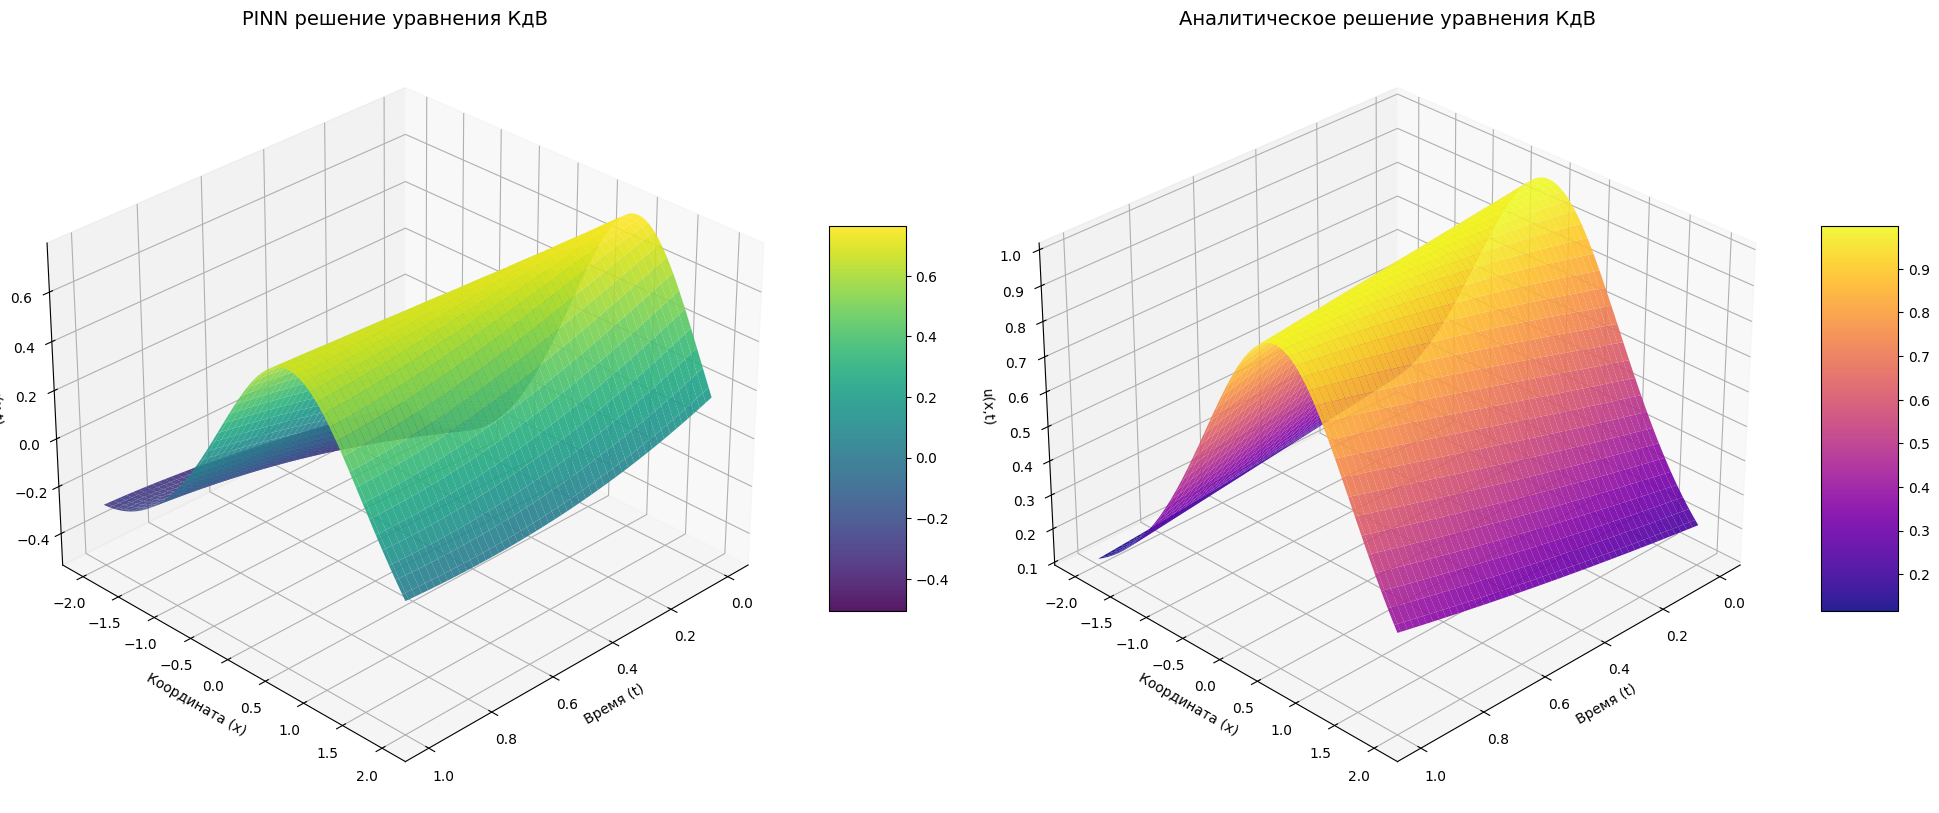

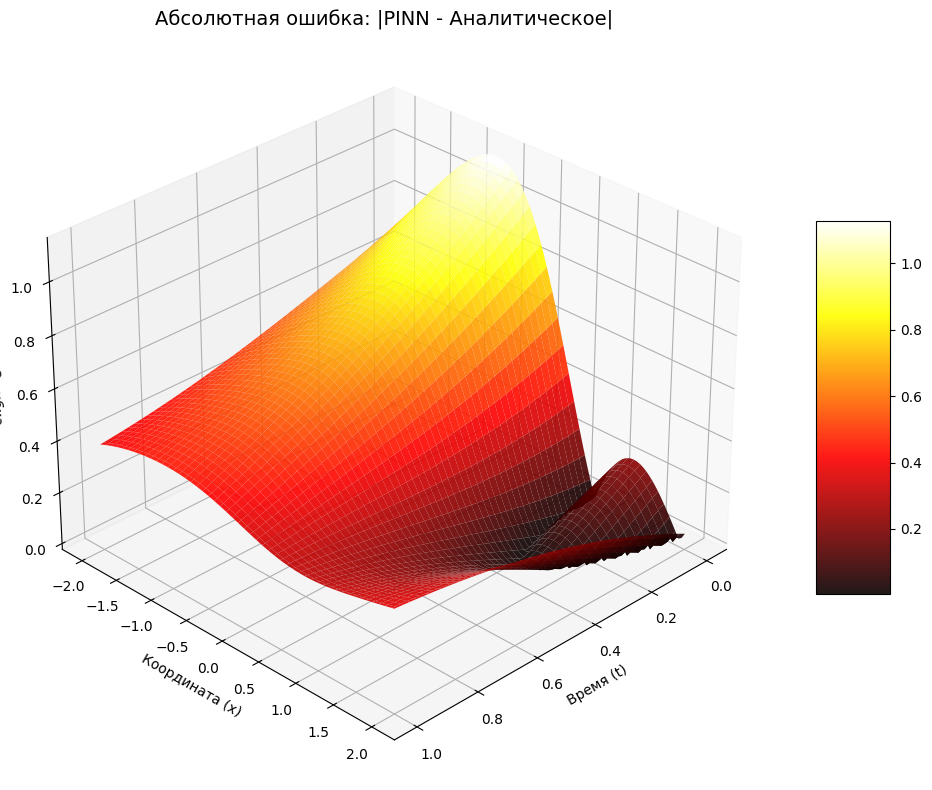

Статистика ошибки:
Средняя ошибка: 0.459271
Максимальная ошибка: 1.138574
Стандартное отклонение: 0.269355


In [10]:
# Создаем сетку для визуализации
x_vis = torch.linspace(-L, L, 100)
t_vis = torch.linspace(0, T, 100)
X, T_vis = torch.meshgrid(x_vis, t_vis, indexing='xy')
points_vis = torch.stack([X.flatten(), T_vis.flatten()], dim=1)

# Вычисляем PINN решение
with torch.no_grad():
    u_pinn = best_model(points_vis).reshape(X.shape)

# Вычисляем аналитическое решение
u_analytical = analytical_kdv_solution(X, T_vis)

# Создаем фигуру с двумя 3D графиками
fig = plt.figure(figsize=(20, 8))

# График 1: PINN решение
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(T_vis.numpy(), X.numpy(), u_pinn.numpy(), 
                        cmap='viridis', alpha=0.9, linewidth=0, 
                        antialiased=True, rstride=2, cstride=2)
ax1.set_xlabel('Время (t)')
ax1.set_ylabel('Координата (x)')
ax1.set_zlabel('u(x,t)')
ax1.set_title('PINN решение уравнения КдВ', fontsize=14)
ax1.view_init(elev=30, azim=45)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# График 2: Аналитическое решение
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(T_vis.numpy(), X.numpy(), u_analytical.numpy(), 
                        cmap='plasma', alpha=0.9, linewidth=0, 
                        antialiased=True, rstride=2, cstride=2)
ax2.set_xlabel('Время (t)')
ax2.set_ylabel('Координата (x)')
ax2.set_zlabel('u(x,t)')
ax2.set_title('Аналитическое решение уравнения КдВ', fontsize=14)
ax2.view_init(elev=30, azim=45)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

# Дополнительно: график ошибки
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

error = torch.abs(u_pinn - u_analytical)
surf_error = ax.plot_surface(T_vis.numpy(), X.numpy(), error.numpy(), 
                           cmap='hot', alpha=0.9, linewidth=0,
                           antialiased=True, rstride=2, cstride=2)
ax.set_xlabel('Время (t)')
ax.set_ylabel('Координата (x)')
ax.set_zlabel('Ошибка')
ax.set_title('Абсолютная ошибка: |PINN - Аналитическое|', fontsize=14)
ax.view_init(elev=30, azim=45)
fig.colorbar(surf_error, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

# Статистика ошибки
print("Статистика ошибки:")
print(f"Средняя ошибка: {error.mean().item():.6f}")
print(f"Максимальная ошибка: {error.max().item():.6f}")
print(f"Стандартное отклонение: {error.std().item():.6f}")